# Aula 9 - InPars

[Unicamp - IA368DD: Deep Learning aplicado a sistemas de busca.](https://www.cpg.feec.unicamp.br/cpg/lista/caderno_horario_show.php?id=1779)

Autor: Marcus Vinícius Borela de Castro

[Repositório no github](https://github.com/marcusborela/deep_learning_em_buscas_unicamp)


# Enunciado exercício



Objetivo: gerar dataset para treino de modelos de buscas usando a técnica do InPars e avaliar um modelo reranqueador treinado neste dataset no TREC-COVID:

Entrada: 3-5 exemplos few-shot + documento amostrado da coleção do TREC-COVID

Saída: query que seja relevante para o documento amostrado

É opcional fazer a etapa de filtragem usando as queries de maior prob descrita no Artigo.

Como modelo gerador, use um dos seguintes modelos:
ChatGPT-3.5-turbo: ~1 USD para cada 1k exemplos
FLAN-T5 (base, large ou XL), LLAMA-(7,13B), Alpaca-(7/13B), que são possiveis de rodar no Colab Pro.

Também tem a inference-api da HF: https://huggingface.co/inference-api.

Com exceção do LLAMA, é possivel usar zero-shot ao inves de few-shot.
Dado 1k-10k pares <query sintética; documento>, treinar um modelo reranqueador miniLM igual ao da aula 2/3.

Exemplos negativos (i.e., <query sintética; doc não relevant) vem do BM25: dado a query sintetica, retornar top 1000 com o BM25, e amostrar aleatoriamente alguns documentos como negativo

Começar treino do miniLM já treinado no MS MARCO

Avaliar no TREC-COVID e comparar com o reranqueador apenas treinado no MSMARCO

Nota: Também usar o dataset dos colegas para obter diversidade de exemplos: Assim que tiver gerado o dataset sintético, favor colocar na planilha, assim outras pessoas podem usa-lo.
- Para aumentar a aleatoriedade, seed usada deve o seu numero na planilha.

Colocar dataset no formato jsonlines:
{"query": query, "positive_doc_id": doc_id, "negative_doc_ids": [opcional]}\n 



Dicas: (do exercício da aula 2)

- Siga sempre um padrão ao criar os exemplos few-shot. Aqui tem uma pagina com dicas para prompt engineering: https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api


- Usar a API do LLAMA fornecida por nós (licença exclusiva para pesquisa). [Colab demo da API do LLAMA](https://colab.research.google.com/drive/1zZ-ch29LTicNPA62t2MaOwMROywnqUxf?usp=sharing) (obrigado, Thales Rogério)
- Opcionalmente, usar a API do code-davinci-002, que é de graça e trás resultados muito bons.
CUIDADO: NÃO USAR O TEXT-DAVINCI-002/003, que é pago

- Opcionalmente, usar a API do ChatGPT (gpt-3.5-turbo) que é barata: ~1 centavo de real por 1000 tokens (uma página)
  
- Opcionalmente, usar o Alpaca: https://alpaca-ai.ngrok.io/



Este caderno contempla o passo 6 (avaliação do pipeline na busca) do [fluxo de processamento](https://github.com/marcusborela/deep_learning_em_buscas_unicamp/blob/main/presentations/articles/Aula%208%20-%20InPars%20Process.png)

# Organizando o ambiente

## Importações

In [1]:
import pandas as pd

In [2]:
from tqdm import tqdm

In [3]:
import os

In [4]:
import pickle

In [5]:
import time

In [6]:
import numpy as np

In [7]:
os.environ['JVM_PATH'] = '/usr/lib/jvm/java-11-openjdk-amd64/lib/server/libjvm.so'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

In [8]:
from pyserini.search.lucene import LuceneSearcher

/home/borela/miniconda3/envs/treinapython39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from evaluate import load

In [10]:
import torch

In [11]:
import gzip, json

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [13]:
from torch.utils.data import DataLoader

In [14]:
from torch.utils.data import Dataset

In [15]:
from transformers import BatchEncoding

## Definindo paths

In [16]:
DIRETORIO_LOCAL = '/home/borela/fontes/deep_learning_em_buscas_unicamp/local'
DIRETORIO_TRABALHO = F'{DIRETORIO_LOCAL}/inpars'
DIRETORIO_TREC_COVID = F'{DIRETORIO_LOCAL}/trec_covid'
DIRETORIO_MSMARCO = F'{DIRETORIO_LOCAL}/msmarco'
DIRETORIO_TREINO = F'{DIRETORIO_TRABALHO}/treino'
DIRETORIO_RUN = f"{DIRETORIO_TRABALHO}/runs"
PATH_RUN_AVALIACAO = f"{DIRETORIO_RUN}/run-trec-covid.txt"
PATH_LISTA_RESULTADO = f"{DIRETORIO_TRABALHO}/lista_resultado_avaliacao.pickle"

In [17]:
if os.path.exists(DIRETORIO_LOCAL):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_LOCAL)
    print('pasta criada!')


pasta já existia!


In [18]:
if os.path.exists(DIRETORIO_TRABALHO):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TRABALHO)
    print('pasta criada!')


pasta já existia!


In [19]:
if os.path.exists(DIRETORIO_TREINO):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TREINO)
    print('pasta criada!')


pasta já existia!


In [20]:
if os.path.exists(DIRETORIO_RUN):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_RUN)
    print('pasta criada!')


pasta já existia!


## Outras inicializações

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Construindo o índice prebuilt trec-covid

In [22]:
LuceneSearcher.from_prebuilt_index('beir-v1.0.0-trec-covid.flat')

In [23]:
os.getcwd()

'/home/borela/fontes/deep_learning_em_buscas_unicamp/code/aula9_inpars'

In [24]:
!ls /home/borela/.cache/pyserini/indexes/

lucene-index.beir-v1.0.0-trec-covid.flat.20221116.505594.57b812594b11d064a23123137ae7dade


In [25]:
NOME_INDICE_TRECC = os.popen('ls /home/borela/.cache/pyserini/indexes/').read()[:-1]

In [26]:
print(NOME_INDICE_TRECC)

lucene-index.beir-v1.0.0-trec-covid.flat.20221116.505594.57b812594b11d064a23123137ae7dade


In [27]:
PATH_INDICE_TRECC = f'/home/borela/.cache/pyserini/indexes/{NOME_INDICE_TRECC}'

In [28]:
os.path.exists(PATH_INDICE_TRECC)

True

# Baixando os dados e preparando para avaliação 

## Documentos

In [29]:
if not os.path.exists(f"{DIRETORIO_TREC_COVID}/corpus.jsonl.gz"):
    !wget https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/corpus.jsonl.gz
    !mv corpus.jsonl.gz {DIRETORIO_TREC_COVID}
    print('Baixado')
else:
    print('Já existia a pasta')

Já existia a pasta


In [30]:
# Descompacte o arquivo para a memória
with gzip.open(f'{DIRETORIO_TREC_COVID}/corpus.jsonl.gz', 'rt') as f:
    # Leia o conteúdo do arquivo descompactado
    corpus = [json.loads(line) for line in f]

In [31]:
# Exiba os dados carregados
print(f"{type(corpus)} len(corpus): {len(corpus)} " )

<class 'list'> len(corpus): 171332 


In [32]:
corpus_dict = {}

for docto in corpus:
    if ('title' in docto) and len(docto['title']) >= 5:
        texto_usado_na_geracao_de_query = docto['title'] + '. ' + docto['text']
    else:
        texto_usado_na_geracao_de_query = docto['text']
    corpus_dict[docto['_id']] = {'text_query_generation': texto_usado_na_geracao_de_query, 
                                 'title': docto['title'],
                                 'text': docto['text']}

In [33]:
print(len(corpus_dict))

171332


## Queries

In [34]:
from pyserini.search import get_topics

In [35]:
topics = get_topics('covid-round5')
print(f'{len(topics)} queries total')

50 queries total


In [77]:
topics[1]

{'question': 'what is the origin of COVID-19',
 'query': 'coronavirus origin',
 'narrative': "seeking range of information about the SARS-CoV-2 virus's origin, including its evolution, animal source, and first transmission into humans"}

## Dados de relevância (qrel de teste)

In [37]:
if not os.path.exists(f'{DIRETORIO_TREC_COVID}/test.tsv'):
    !wget https://huggingface.co/datasets/BeIR/trec-covid-qrels/raw/main/test.tsv
    !mv test.tsv {DIRETORIO_LOCAL}/
else:
    print('Arquivo já existia')

Arquivo já existia


In [38]:
qrel = pd.read_csv(f"{DIRETORIO_TREC_COVID}/test.tsv", sep="\t", header=None, 
                   skiprows=1, names=["query", "docid", "rel"])

In [39]:
qrel.head()

,query,docid,rel
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,g7dhmyyo,2
3,1,0194oljo,1
4,1,021q9884,1


In [40]:
qrel.head()

,query,docid,rel
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,g7dhmyyo,2
3,1,0194oljo,1
4,1,021q9884,1


In [41]:
qrel["q0"] = "q0"
qrel_dict = qrel.to_dict(orient="list")

In [42]:
qrel_dict['query'][0], qrel_dict['docid'][0], qrel_dict['rel'][0]

(1, '005b2j4b', 2)

# Realiza buscas e avaliações

## Objetos de apoio

In [43]:
lista_resultados = []

In [44]:
trec_eval = load("trec_eval")

In [45]:
num_max_hits = 1000

In [46]:
# Run all queries in topics, retrive top 1k for each query
def run_all_queries(file, topics, searcher, num_max_hits=100):
  """
  A função run_all_queries é responsável por realizar todas as consultas armazenadas no dicionário topics utilizando o objeto searcher fornecido e salvar os resultados em um arquivo de texto.
  Usada no notebook da aula 2

  Parâmetros:

  file: caminho do arquivo de saída onde serão salvos os resultados das consultas.
  topics: dicionário contendo as consultas a serem executadas. Cada consulta é representada por uma chave única no dicionário. O valor correspondente a cada chave é um outro dicionário contendo as informações da consulta, como seu título e outras informações relevantes.
  searcher: objeto do tipo Searcher que será utilizado para realizar as consultas.
  num_max_hits: número máximo de documentos relevantes que serão retornados para cada consulta.
  Retorno:

  A função não retorna nenhum valor, mas salva os resultados das consultas no arquivo especificado em file.
  Comentário:

  A função usa a biblioteca tqdm para exibir uma barra de progresso enquanto executa as consultas.
  O número de consultas concluídas é impresso a cada 100 consultas.
  """
  print(f'Running {len(topics)} queries in total')
  with open(file, 'w') as runfile:
    cnt = 0
    for id in tqdm(topics, desc='Running Queries'):
        # print(f'id = {id}')
        query = topics[id]['question']
        # print(f'query = {query}')

        hits = searcher.search(query, num_max_hits)
        for i in range(0, len(hits)):
            _ = runfile.write(f'{id} Q0 {hits[i].docid} {i+1} {hits[i].score:.6f} Busca\n')
            # = runfile.write('{} Q0 {} {} {:.6f} Pyserini\n'.format(id, hits[i].docid, i+1, hits[i].score))
        cnt += 1
        if cnt % 100 == 0:
            print(f'{cnt} queries completed')


In [47]:
searcher = LuceneSearcher(PATH_INDICE_TRECC) # './indexes/lucene-index-msmarco-passage')

## Busca BM25 (parâmetros default)

### Busca

In [48]:
searcher.set_bm25(k1=0.9, b=0.4)   # valores default, conforme paper InPars

In [49]:
run_all_queries(PATH_RUN_AVALIACAO, topics, searcher, num_max_hits)

Running 50 queries in total


Running Queries: 100%|██████████| 50/50 [00:02<00:00, 21.10it/s]


### Avaliação

In [50]:
### Calculando métricas
run = pd.read_csv(f"{PATH_RUN_AVALIACAO}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

   query  q0     docid  rank      score system
0     44  Q0  xfjexm5b     1  12.713800  Busca
1     44  Q0  28utunid     2  11.653200  Busca
2     44  Q0  qi1henyy     3  11.653199  Busca
3     44  Q0  qp77vl6h     4  11.350500  Busca
4     44  Q0  ugkxxaeb     5  11.312800  Busca


In [51]:
results = trec_eval.compute(predictions=[run], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.5946917010118077
Resultados: {'runid': 'Busca', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9605, 'num_q': 50, 'map': 0.18712850250314475, 'gm_map': 0.1248255966783779, 'bpref': 0.32940840203100064, 'Rprec': 0.28470678646102393, 'recip_rank': 0.8528571428571429, 'P@5': 0.6880000000000002, 'P@10': 0.644, 'P@15': 0.608, 'P@20': 0.5989999999999999, 'P@30': 0.5753333333333334, 'P@100': 0.4718, 'P@200': 0.39480000000000004, 'P@500': 0.27664, 'P@1000': 0.19210000000000005, 'NDCG@5': 0.6323889863121053, 'NDCG@10': 0.5946917010118077, 'NDCG@15': 0.561630324213359, 'NDCG@20': 0.5463332676967534, 'NDCG@30': 0.5233190162754622, 'NDCG@100': 0.43823617750837557, 'NDCG@200': 0.38302424232653026, 'NDCG@500': 0.3554494781191315, 'NDCG@1000': 0.405955738412841}


In [52]:
lista_resultados.append(
{'retriever': 'bm25',
 'details': 'k1=0.9, b=0.4',
 "ndcg":round(100*results['NDCG@10'],2)})

## Busca BM25 (parâmetros k1=1.12, b=0.4)

### Busca

In [54]:
searcher.set_bm25(k1=1.12, b=0.4)    # valor sugerido pelo Carísio em seu grid na tarefa Doc2Query

In [55]:
run_all_queries(PATH_RUN_AVALIACAO, topics, searcher, num_max_hits)

Running 50 queries in total


Running Queries: 100%|██████████| 50/50 [00:01<00:00, 26.54it/s]


### Avaliação

In [56]:
### Calculando métricas
run = pd.read_csv(f"{PATH_RUN_AVALIACAO}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

   query  q0     docid  rank      score system
0     44  Q0  xfjexm5b     1  11.889200  Busca
1     44  Q0  28utunid     2  10.906200  Busca
2     44  Q0  qi1henyy     3  10.906199  Busca
3     44  Q0  ugkxxaeb     4  10.638000  Busca
4     44  Q0  qp77vl6h     5  10.487900  Busca


In [57]:
results = trec_eval.compute(predictions=[run], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.6187936694210939
Resultados: {'runid': 'Busca', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.19397103009765435, 'gm_map': 0.13129328791759654, 'bpref': 0.334829488236771, 'Rprec': 0.28961812585830815, 'recip_rank': 0.8518571428571429, 'P@5': 0.7080000000000001, 'P@10': 0.67, 'P@15': 0.6453333333333333, 'P@20': 0.6199999999999999, 'P@30': 0.5946666666666667, 'P@100': 0.48460000000000003, 'P@200': 0.4014000000000001, 'P@500': 0.28308, 'P@1000': 0.19608, 'NDCG@5': 0.6494195661372965, 'NDCG@10': 0.6187936694210939, 'NDCG@15': 0.5930265595572919, 'NDCG@20': 0.5686991493574204, 'NDCG@30': 0.5424134242812346, 'NDCG@100': 0.45176650622218156, 'NDCG@200': 0.39092334821357283, 'NDCG@500': 0.3643405602785105, 'NDCG@1000': 0.4143286268113492}


In [58]:
lista_resultados.append(
{'retriever': 'bm25',
 'details': 'k1=1.12, b=0.4',
 "ndcg":round(100*results['NDCG@10'],2)})

In [59]:
lista_resultados

[{'retriever': 'bm25', 'details': 'k1=0.9, b=0.4', 'ndcg': 59.47},
 {'retriever': 'bm25', 'details': 'k1=1.12, b=0.4', 'ndcg': 61.88}]

In [60]:
run_estagio_1 = run # servirá como estágio 1

## Preparação para reranking

In [61]:
class MyDataset(Dataset):
    """
      Classe para representar um dataset de texto e classes.
    """  
    def __init__(self, texts: np.ndarray, classes:list[int], tokenizer):
      """
      Inicializa um novo objeto MyDataset.

      Args:
          texts (np.ndarray): um array com as strings de texto. Cada linha deve ter 2 strings.
          classes (np.ndarray): um array com as classes de cada texto.
          tokenizer: um objeto tokenizer do Hugging Face Transformers.
          max_seq_length (int): o tamanho máximo da sequência a ser considerado.
      Raises:
          AssertionError: se os parâmetros não estiverem no formato esperado.
      """
      # Verifica se os parâmetros são do tipo esperado
      assert isinstance(texts, np.ndarray), f"Parâmetro texts deve ser do tipo np.ndarray e não {type(texts)}"
      assert texts.shape[1] == 2, "Array must have 2 columns"
      for row in texts:
          assert isinstance(row, np.ndarray) and row.shape == (2,), f"Each row in texts must have 2 elements"
          assert isinstance(row[0], str) and isinstance(row[1], str), f"Each element in texts.row must be a string e não {type(row[0])}"
      assert isinstance(classes,np.ndarray), f'classes deve ser do tipo np.ndarray e não {type(classes)}'
      assert isinstance(classes[0],np.int64), f'classes[0] deve ser do tipo numpy.int64 e não {type(classes[0])} '

      self.texts = texts
      self.classes = classes
      self.tokenizer = tokenizer
      self.max_seq_length = tokenizer.model_max_length # model.config.max_position_embeddings
      if self.max_seq_length > 64000:
        print(f"Valor de self.max_seq_length  {self.max_seq_length} indica que deve ser usado outro campo do tokenizador. Assumido 512 ")
        self.max_seq_length =  512
      # Salvar os dados dos tensores
      x_data_input_ids = []
      x_data_token_type_ids = []
      x_data_attention_masks = []
      for text_pair in tqdm(texts, desc='encoding text pair'):
          encoding = tokenizer.encode_plus(
              text_pair[0],
              text_pair[1],
              add_special_tokens=True,
              max_length=self.max_seq_length,
              padding='max_length',
              return_tensors = 'pt',
              truncation=True,
              return_attention_mask=True,
              return_token_type_ids=True
          )
          x_data_input_ids.append(encoding['input_ids'].long())
          x_data_token_type_ids.append(encoding['token_type_ids'].long())
          x_data_attention_masks.append(encoding['attention_mask'].long())
      print(F'\tVou converter lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      # squeeze: vai transformar um tensor de shape [2, 1, 322] em um tensor de shape [2, 322].

      self.x_tensor_input_ids = torch.stack(x_data_input_ids).squeeze(1)
      self.x_tensor_attention_masks = torch.stack(x_data_attention_masks).squeeze(1)
      self.x_tensor_token_type_ids = torch.stack(x_data_token_type_ids).squeeze(1)

    def __len__(self):
        """
          Retorna o tamanho do dataset (= tamanho do array texts)
        """
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
          Retorna um dicionário com os dados do texto e sua classe correspondente, em um formato que pode 
          ser usado pelo dataloader do PyTorch para alimentar um modelo de aprendizado de máquina.
        """
        return {
            'input_ids': self.x_tensor_input_ids[idx],
            'attention_mask': self.x_tensor_attention_masks[idx],
            'token_type_ids': self.x_tensor_token_type_ids[idx],
            # 'labels': int(self.classes[idx])
            'labels': torch.tensor(self.classes[idx], dtype=torch.long)            
        }

In [62]:
def calcula_relevancia(parm_model, parm_dataloader_reranking):
  # para 'cross-encoder/ms-marco-TinyBERT-L-2'
  prob_relevancia = []
  parm_model.eval()
  with torch.no_grad():
      for ndx, batch in tqdm(enumerate(parm_dataloader_reranking), total=len(parm_dataloader_reranking), mininterval=0.5, desc='dataset_reranking', disable=False):
          logits_model = parm_model(**BatchEncoding(batch).to(device)).logits                          
          relevantes_float = [float(t) for t in logits_model]
          prob_relevancia.extend(relevantes_float)          
          # prob_relevancia.append(pa.array(scores.numpy()))
  return prob_relevancia

In [63]:
def calcula_relevancia_minilm(parm_model, parm_dataloader_reranking):
  prob_relevancia = []
  parm_model.eval()
  with torch.no_grad():
      for ndx, batch in tqdm(enumerate(parm_dataloader_reranking), total=len(parm_dataloader_reranking), mininterval=0.5, desc='dataset_reranking', disable=False):
          #print("\nbatch['input_ids'][0]", batch['input_ids'][0])
          #print("batch['input_ids'][1]", batch['input_ids'][1])
          logits_model = parm_model(**BatchEncoding(batch).to(device)).logits
          probs = torch.nn.functional.softmax(logits_model, dim=1)
          nao_relevante, relevante = zip(*probs)
          relevantes_float = [float(t) for t in relevante]
          # print('logits_model', logits_model)
          prob_relevancia.extend(relevantes_float)
          # prob_relevancia.append(pa.array(scores.numpy()))
          # print('probs',probs)
          # print('relevantes_float',relevantes_float)
          # break
  return prob_relevancia

In [64]:
# aproveitamos saída do bm25 com melhor ndcg@10 testado
run_estagio_1.keys()

dict_keys(['query', 'q0', 'docid', 'rank', 'score', 'system'])

In [65]:
len(run_estagio_1['query'])

50000

In [66]:
run_estagio_1['query'][0], run_estagio_1['q0'][0], run_estagio_1['docid'][0], run_estagio_1['rank'][0], run_estagio_1['score'][0], run_estagio_1['system'][0]

(44, 'Q0', 'xfjexm5b', 1, 11.8892, 'Busca')

In [67]:
df_reranking_entrada = pd.DataFrame(run_estagio_1)

In [79]:
df_reranking_entrada.shape

(50000, 8)

Acrescentar o texto da query e o texto do documento

In [69]:
topics[1]

{'question': 'what is the origin of COVID-19',
 'query': 'coronavirus origin',
 'narrative': "seeking range of information about the SARS-CoV-2 virus's origin, including its evolution, animal source, and first transmission into humans"}

In [70]:
df_reranking_entrada['query_text'] = df_reranking_entrada['query'].apply(lambda x: topics[x]['question'])

In [71]:
df_reranking_entrada.head()

,query,q0,docid,rank,score,system,query_text
0,44,Q0,xfjexm5b,1,11.889200,Busca,How much impact do masks have on preventing th...
1,44,Q0,28utunid,2,10.906200,Busca,How much impact do masks have on preventing th...
2,44,Q0,qi1henyy,3,10.906199,Busca,How much impact do masks have on preventing th...
3,44,Q0,ugkxxaeb,4,10.638000,Busca,How much impact do masks have on preventing th...
4,44,Q0,qp77vl6h,5,10.487900,Busca,How much impact do masks have on preventing th...


In [72]:
corpus_dict['xfjexm5b']['text_query_generation'][:30]

'Impact of self-imposed prevent'

In [73]:
df_reranking_entrada['doc_text'] = df_reranking_entrada['docid'].apply(lambda x: corpus_dict[x]['text_query_generation'])

In [74]:
df_reranking_entrada.head()

,query,q0,docid,rank,score,system,query_text,doc_text
0,44,Q0,xfjexm5b,1,11.889200,Busca,How much impact do masks have on preventing th...,Impact of self-imposed prevention measures and...
1,44,Q0,28utunid,2,10.906200,Busca,How much impact do masks have on preventing th...,To mask or not to mask: Modeling the potential...
2,44,Q0,qi1henyy,3,10.906199,Busca,How much impact do masks have on preventing th...,To mask or not to mask: Modeling the potential...
3,44,Q0,ugkxxaeb,4,10.638000,Busca,How much impact do masks have on preventing th...,Masking the general population might attenuate...
4,44,Q0,qp77vl6h,5,10.487900,Busca,How much impact do masks have on preventing th...,Analysis on Novel Coronavirus (COVID-19) Using...


In [75]:
df_reranking_entrada['query_text'] = df_reranking_entrada['query_text'].astype(str)
df_reranking_entrada['doc_text'] = df_reranking_entrada['doc_text'].astype(str)

In [80]:
del df_reranking_entrada['system']

In [81]:
df_reranking_entrada.rename(columns={'rank': 'rank_estagio1', 'score': 'score_estagio1'}, inplace=True)

In [82]:
df_reranking_entrada.to_csv(f"{DIRETORIO_TRABALHO}/df_reranking_entrada.csv")

## Modelo de teste (treinado no ms-marco)

In [83]:
nome_modelo = 'cross-encoder/ms-marco-TinyBERT-L-2'
model = AutoModelForSequenceClassification.from_pretrained(nome_modelo).to(device)
tokenizer = AutoTokenizer.from_pretrained(nome_modelo)

In [84]:
model.config.max_position_embeddings, tokenizer.max_len_sentences_pair, tokenizer.model_max_length

(512, 509, 512)

In [85]:
%%time
print("carregando dataset")  
classes_dummy = np.zeros(len(df_reranking_entrada), dtype=np.int64)
print(classes_dummy.shape)
dataset_reranking = MyDataset(texts=df_reranking_entrada[['query_text','doc_text']].values, classes=classes_dummy, tokenizer=tokenizer)    

carregando dataset
(50000,)


encoding text pair: 100%|██████████| 50000/50000 [00:47<00:00, 1046.50it/s]


	Vou converter lista para tensor;  Momento: [2023-mai-03 18:37:42]
CPU times: user 48 s, sys: 341 ms, total: 48.3 s
Wall time: 48.2 s


In [86]:
dataloader_reranking = DataLoader(dataset_reranking,
                                  batch_size= 4, 
                                  shuffle=False)

In [87]:
%%time
prob_relevancia_tinybert = calcula_relevancia(model,dataloader_reranking)

dataset_reranking: 100%|██████████| 12500/12500 [00:37<00:00, 330.84it/s]

CPU times: user 37.7 s, sys: 120 ms, total: 37.8 s
Wall time: 37.8 s


In [88]:
df_reranking_entrada['score_tinybert'] = prob_relevancia_tinybert

In [89]:
# Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values(['score_tinybert'], ascending=[False]))

In [90]:
df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1

In [91]:
df_reranking[df_reranking['query']==44]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,reranking
5,44,Q0,ej76fsxa,6,10.013600,How much impact do masks have on preventing th...,"Teach, and teach and teach: does the average c...",3.942430,1
87,44,Q0,1oth8r7g,88,8.159400,How much impact do masks have on preventing th...,Understanding the spreading patterns of COVID-...,3.929078,2
773,44,Q0,z59cvvkf,774,6.355699,How much impact do masks have on preventing th...,Environmental perspective of COVID-19. The out...,3.883955,3
448,44,Q0,9b6cepf4,449,6.836400,How much impact do masks have on preventing th...,Community Use Of Face Masks And COVID-19: Evid...,3.792098,4
772,44,Q0,j4hnldk4,773,6.355700,How much impact do masks have on preventing th...,Environmental perspective of COVID-19. Abstrac...,3.779235,5
...,...,...,...,...,...,...,...,...,...
541,44,Q0,p8jrm5df,542,6.664600,How much impact do masks have on preventing th...,Navigating the Zika panic.. The epidemics of E...,-6.976887,996
926,44,Q0,qdy29oym,927,6.206700,How much impact do masks have on preventing th...,Seeking Membranes: Positive-Strand RNA Virus R...,-6.994773,997
568,44,Q0,yajnzgd5,569,6.608700,How much impact do masks have on preventing th...,"Unconscious Bias, Racism, and Trauma-Informed ...",-6.997178,998
158,44,Q0,gwg7vnkv,159,7.687600,How much impact do masks have on preventing th...,Scientific Opinion on an update on the present...,-6.998663,999


### Avaliação

In [92]:
df_reranking.rename(columns={'reranking': 'rank', 'score_tinybert':'score'}, inplace=True)

In [93]:
df_reranking['q0'] = 'q0'
df_reranking['system'] = 'tinybert'

In [94]:
df_reranking.iloc[1995:2005]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score,rank,system
18393,2,q0,4grjr0h3,394,4.481100,how does the coronavirus respond to changes in...,Unified feature association networks through i...,-7.048757,996,tinybert
18451,2,q0,pabdj7v4,452,4.360500,how does the coronavirus respond to changes in...,Health workers' perceptions and experiences of...,-7.048936,997,tinybert
18430,2,q0,if4w9vg4,431,4.403200,how does the coronavirus respond to changes in...,Are your cash-flow tools recession ready?. Abs...,-7.050327,998,tinybert
18751,2,q0,i64q5d26,752,3.966199,how does the coronavirus respond to changes in...,On-farm biosecurity as perceived by profession...,-7.050867,999,tinybert
18739,2,q0,gwjgngk7,740,3.978300,how does the coronavirus respond to changes in...,"Higher tourism specialization, better hotel in...",-7.058733,1000,tinybert
19123,3,q0,t3sjv4hv,124,7.711899,will SARS-CoV2 infected people develop immunit...,SARS-CoV-2 infection protects against rechalle...,3.426975,1,tinybert
19122,3,q0,car394ou,123,7.711900,will SARS-CoV2 infected people develop immunit...,SARS-CoV-2 infection protects against rechalle...,3.413507,2,tinybert
19092,3,q0,aed6psww,93,7.939200,will SARS-CoV2 infected people develop immunit...,A case report of possible novel coronavirus 20...,3.402295,3,tinybert
19010,3,q0,wfftfkam,11,9.550200,will SARS-CoV2 infected people develop immunit...,COVID‐19 is milder in children possibly due to...,3.224682,4,tinybert
19065,3,q0,bcqdm2b1,66,8.117100,will SARS-CoV2 infected people develop immunit...,Protective Adaptive Immunity Against Severe Ac...,2.991671,5,tinybert


In [95]:
run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")

In [96]:
run_reranking.keys()

dict_keys(['query', 'q0', 'docid', 'rank', 'score', 'system'])

In [97]:
run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0]

(1, 'q0', 'pbj819vk', 1, 4.17462158203125, 'tinybert')

In [98]:
results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.5367637984598898
Resultados: {'runid': 'tinybert', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.163296159555747, 'gm_map': 0.11172482777651789, 'bpref': 0.3436004688708574, 'Rprec': 0.2712226646580145, 'recip_rank': 0.7893571428571429, 'P@5': 0.6240000000000001, 'P@10': 0.6099999999999999, 'P@15': 0.5746666666666667, 'P@20': 0.534, 'P@30': 0.522, 'P@100': 0.4016, 'P@200': 0.34619999999999995, 'P@500': 0.26812, 'P@1000': 0.19608, 'NDCG@5': 0.5450837322710362, 'NDCG@10': 0.5367637984598898, 'NDCG@15': 0.5138097775657847, 'NDCG@20': 0.48838865129135023, 'NDCG@30': 0.4710598474915368, 'NDCG@100': 0.37673251181712836, 'NDCG@200': 0.33371232857173694, 'NDCG@500': 0.33290366745803396, 'NDCG@1000': 0.39601553171132203}


In [99]:
lista_resultados.append(
{'retriever': 'reranking_tinybert',
 'details': 'ms-marco-TinyBERT-L-2; pretreinado no msmarco',
 "ndcg":round(100*results['NDCG@10'],2)})

In [100]:
lista_resultados

[{'retriever': 'bm25', 'details': 'k1=0.9, b=0.4', 'ndcg': 59.47},
 {'retriever': 'bm25', 'details': 'k1=1.12, b=0.4', 'ndcg': 61.88},
 {'retriever': 'reranking_tinybert',
  'details': 'ms-marco-TinyBERT-L-2; pretreinado no msmarco',
  'ndcg': 53.68}]

## Preparando datase e dataloader para minilm

In [101]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/MiniLM-L12-H384-uncased')

In [102]:
%%time
print("carregando dataset")  
classes_dummy = np.zeros(len(df_reranking_entrada), dtype=np.int64)
print(classes_dummy.shape)
dataset_reranking = MyDataset(texts=df_reranking_entrada[['query_text','doc_text']].values, classes=classes_dummy, tokenizer=tokenizer)    

carregando dataset
(50000,)
Valor de self.max_seq_length  1000000000000000019884624838656 indica que deve ser usado outro campo do tokenizador. Assumido 512 


encoding text pair: 100%|██████████| 50000/50000 [00:46<00:00, 1065.50it/s]


	Vou converter lista para tensor;  Momento: [2023-mai-03 18:39:28]
CPU times: user 47.2 s, sys: 276 ms, total: 47.4 s
Wall time: 47.3 s


In [103]:
dataloader_reranking = DataLoader(dataset_reranking,
                                  batch_size= 4, 
                                  shuffle=False)

## Modelo minilm com finetune no InPars formado por dataset dos colegas e 10k próprios (v1)

In [104]:
# inicializa o modelo como AutoModelForSequenceClassification
path_modelo = f'{DIRETORIO_TREINO}/model_fim_treino_10k_ds.pt'
model = AutoModelForSequenceClassification.from_pretrained(path_modelo).to(device)


In [105]:
model.config.max_position_embeddings, tokenizer.max_len_sentences_pair, tokenizer.model_max_length

(512, 1000000000000000019884624838653, 1000000000000000019884624838656)

In [106]:
%%time
prob_relevancia_inpars_10k_ds = calcula_relevancia_minilm(model,dataloader_reranking)

dataset_reranking: 100%|██████████| 12500/12500 [04:27<00:00, 46.75it/s]

CPU times: user 4min 27s, sys: 108 ms, total: 4min 27s
Wall time: 4min 27s


In [107]:
df_reranking_entrada['score_inpars_10k_ds'] = prob_relevancia_inpars_10k_ds

In [108]:
# Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values(['score_inpars_10k_ds'], ascending=[False]))
df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1
df_reranking[df_reranking['query']==44]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score_inpars_10k_ds,reranking
90,44,Q0,wni08lks,91,8.1508,How much impact do masks have on preventing th...,COVID‐19: Face masks and human‐to‐human transm...,2.450861,0.999384,1
120,44,Q0,q0ey3wib,121,7.9099,How much impact do masks have on preventing th...,Coronavirus infection prevention by wearing ma...,2.588499,0.999383,2
511,44,Q0,m17j5u0y,512,6.7228,How much impact do masks have on preventing th...,The scientific rationale for the use of simple...,1.922058,0.999379,3
932,44,Q0,r66eulqj,933,6.1921,How much impact do masks have on preventing th...,Masks and thermometers: Paramount measures to ...,2.211510,0.999377,4
315,44,Q0,f4uh73j7,316,7.1306,How much impact do masks have on preventing th...,"Who is wearing a mask? Gender-, age-, and loca...",2.473369,0.999376,5
...,...,...,...,...,...,...,...,...,...,...
158,44,Q0,gwg7vnkv,159,7.6876,How much impact do masks have on preventing th...,Scientific Opinion on an update on the present...,-6.998663,0.000374,996
68,44,Q0,zznjqdx2,69,8.3636,How much impact do masks have on preventing th...,Evaluating Protective Effects of Vaccination. ...,-6.926301,0.000373,997
541,44,Q0,p8jrm5df,542,6.6646,How much impact do masks have on preventing th...,Navigating the Zika panic.. The epidemics of E...,-6.976887,0.000372,998
590,44,Q0,1atoairy,591,6.5859,How much impact do masks have on preventing th...,Autopsy Biosafety: Recommendations for Prevent...,-6.192401,0.000372,999


In [109]:
### Avaliação
df_reranking.rename(columns={'reranking': 'rank', 'score_inpars_10k_ds':'score'}, inplace=True)
df_reranking['q0'] = 'q0'
df_reranking['system'] = 'inpars_10k_ds'
df_reranking.iloc[1995:2005]


,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score,rank,system
18833,2,q0,c0dw73gf,834,3.884500,how does the coronavirus respond to changes in...,"Test, track, and trace: How is the NHSX Covid ...",-7.035064,0.000390,996,inpars_10k_ds
18688,2,q0,kwqnrkh2,689,4.030194,how does the coronavirus respond to changes in...,Responding to COVID-19: how an academic infect...,-6.922223,0.000390,997,inpars_10k_ds
18469,2,q0,twox681w,470,4.311000,how does the coronavirus respond to changes in...,Climate Change and Health: Transcending Silos ...,-6.706432,0.000385,998,inpars_10k_ds
18245,2,q0,vy1mu04l,246,4.827100,how does the coronavirus respond to changes in...,How will this continue? Modelling interactions...,-6.979988,0.000383,999,inpars_10k_ds
18379,2,q0,guevcs1y,380,4.515400,how does the coronavirus respond to changes in...,From SARS to strategic actions reframing syste...,-7.006756,0.000378,1000,inpars_10k_ds
19077,3,q0,tveeq4fj,78,8.048100,will SARS-CoV2 infected people develop immunit...,SARS-CoV-2 Antibody Testing – Questions to be ...,2.159944,0.999316,1,inpars_10k_ds
19049,3,q0,88px7oq2,50,8.451300,will SARS-CoV2 infected people develop immunit...,T cells found in COVID-19 patients ‘bode well’...,2.846820,0.999311,2,inpars_10k_ds
19079,3,q0,fj2rjmop,80,8.039200,will SARS-CoV2 infected people develop immunit...,Airway Memory CD4(+) T Cells Mediate Protectiv...,2.519732,0.999299,3,inpars_10k_ds
19070,3,q0,rsz7ch2a,71,8.087899,will SARS-CoV2 infected people develop immunit...,Protective immunity after COVID-19 has been qu...,2.064329,0.999281,4,inpars_10k_ds
19520,3,q0,mtq6yh25,521,6.470100,will SARS-CoV2 infected people develop immunit...,Insights on cross-species transmission of SARS...,2.425743,0.999272,5,inpars_10k_ds


In [110]:
run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")
print(run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0])

1 q0 jowrpwbs 1 0.999416708946228 inpars_10k_ds


In [111]:
results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.6209670476243648
Resultados: {'runid': 'inpars_10k_ds', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.19551193783834894, 'gm_map': 0.14266272369560792, 'bpref': 0.3495297349258159, 'Rprec': 0.297070844621028, 'recip_rank': 0.8699523809523809, 'P@5': 0.708, 'P@10': 0.684, 'P@15': 0.652, 'P@20': 0.633, 'P@30': 0.5933333333333334, 'P@100': 0.47159999999999996, 'P@200': 0.4, 'P@500': 0.28628, 'P@1000': 0.19608, 'NDCG@5': 0.6377596509907975, 'NDCG@10': 0.6209670476243648, 'NDCG@15': 0.5993653829895373, 'NDCG@20': 0.5808133104518566, 'NDCG@30': 0.550441178845339, 'NDCG@100': 0.4480321076630382, 'NDCG@200': 0.394298186022022, 'NDCG@500': 0.3725742280763166, 'NDCG@1000': 0.418425291700766}


In [112]:
lista_resultados.append(
{'retriever': 'inpars_10k_ds',
 'details': 'minilm finetuned by InPars; 10k + dataset class',
 "ndcg":round(100*results['NDCG@10'],2)})
lista_resultados

[{'retriever': 'bm25', 'details': 'k1=0.9, b=0.4', 'ndcg': 59.47},
 {'retriever': 'bm25', 'details': 'k1=1.12, b=0.4', 'ndcg': 61.88},
 {'retriever': 'reranking_tinybert',
  'details': 'ms-marco-TinyBERT-L-2; pretreinado no msmarco',
  'ndcg': 53.68},
 {'retriever': 'inpars_10k_ds',
  'details': 'minilm finetuned by InPars; 10k + dataset class',
  'ndcg': 62.1}]

## Modelo minilm com finetune no InPars formado por dataset dos colegas, 30k próprios (v2) e msmarco

In [113]:
# inicializa o modelo como AutoModelForSequenceClassification
path_modelo = f'{DIRETORIO_TREINO}/model_fim_treino_30k_ds_msmarco.pt'
model = AutoModelForSequenceClassification.from_pretrained(path_modelo).to(device)

In [114]:
model.config.max_position_embeddings, tokenizer.max_len_sentences_pair, tokenizer.model_max_length

(512, 1000000000000000019884624838653, 1000000000000000019884624838656)

In [115]:
%%time
prob_relevancia_inpars_30k_ds_msmarco = calcula_relevancia_minilm(model,dataloader_reranking)

dataset_reranking: 100%|██████████| 12500/12500 [04:30<00:00, 46.22it/s]

CPU times: user 4min 30s, sys: 128 ms, total: 4min 30s
Wall time: 4min 30s


In [116]:
df_reranking_entrada['score_inpars_30k_ds_msmarco'] = prob_relevancia_inpars_30k_ds_msmarco

In [117]:
# Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values(['score_inpars_30k_ds_msmarco'], ascending=[False]))
df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1
df_reranking[df_reranking['query']==44]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score_inpars_10k_ds,score_inpars_30k_ds_msmarco,reranking
90,44,Q0,wni08lks,91,8.150800,How much impact do masks have on preventing th...,COVID‐19: Face masks and human‐to‐human transm...,2.450861,0.999384,0.999705,1
120,44,Q0,q0ey3wib,121,7.909900,How much impact do masks have on preventing th...,Coronavirus infection prevention by wearing ma...,2.588499,0.999383,0.999702,2
22,44,Q0,tfrawa9z,23,9.314899,How much impact do masks have on preventing th...,COVID-19: emerging protective measures.. The C...,2.936950,0.999366,0.999701,3
21,44,Q0,qi8x5yaq,22,9.314900,How much impact do masks have on preventing th...,COVID-19: emerging protective measures. The CO...,3.049641,0.999365,0.999701,4
932,44,Q0,r66eulqj,933,6.192100,How much impact do masks have on preventing th...,Masks and thermometers: Paramount measures to ...,2.211510,0.999377,0.999700,5
...,...,...,...,...,...,...,...,...,...,...,...
360,44,Q0,u3y54g8l,361,6.997000,How much impact do masks have on preventing th...,Hesitance towards voluntary medical male circu...,-6.943799,0.000379,0.000197,996
606,44,Q0,2t3iryv5,607,6.567000,How much impact do masks have on preventing th...,Appropriate protein and specific amino acid de...,-6.595015,0.000375,0.000196,997
68,44,Q0,zznjqdx2,69,8.363600,How much impact do masks have on preventing th...,Evaluating Protective Effects of Vaccination. ...,-6.926301,0.000373,0.000196,998
649,44,Q0,kh3musfl,650,6.507099,How much impact do masks have on preventing th...,A New Coefficient of Rankings Similarity in De...,-6.864759,0.000389,0.000195,999


In [118]:
### Avaliação
df_reranking.rename(columns={'reranking': 'rank', 'score_inpars_30k_ds_msmarco':'score'}, inplace=True)
df_reranking['q0'] = 'q0'
df_reranking['system'] = 'inpars_10k_ds'
df_reranking.iloc[1995:2005]


,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score_inpars_10k_ds,score,rank,system
18860,2,q0,scyhqy48,861,3.853300,how does the coronavirus respond to changes in...,Nationalizing a global phenomenon: A study of ...,-6.723236,0.000433,0.000199,996,inpars_10k_ds
18943,2,q0,rr249wro,944,3.798599,how does the coronavirus respond to changes in...,How do agribusinesses thrive through complexit...,-7.032740,0.000428,0.000199,997,inpars_10k_ds
18099,2,q0,6dvxmu8k,100,5.395300,how does the coronavirus respond to changes in...,Navigating crisis from the backseat? How top m...,-7.031188,0.000396,0.000198,998,inpars_10k_ds
18325,2,q0,r4q9zr9q,326,4.634800,how does the coronavirus respond to changes in...,Does relational mobility vary across national ...,-7.023912,0.000432,0.000198,999,inpars_10k_ds
18739,2,q0,gwjgngk7,740,3.978300,how does the coronavirus respond to changes in...,"Higher tourism specialization, better hotel in...",-7.058733,0.000435,0.000197,1000,inpars_10k_ds
19079,3,q0,fj2rjmop,80,8.039200,will SARS-CoV2 infected people develop immunit...,Airway Memory CD4(+) T Cells Mediate Protectiv...,2.519732,0.999299,0.999683,1,inpars_10k_ds
19070,3,q0,rsz7ch2a,71,8.087899,will SARS-CoV2 infected people develop immunit...,Protective immunity after COVID-19 has been qu...,2.064329,0.999281,0.999660,2,inpars_10k_ds
19069,3,q0,rs79r7kc,70,8.087900,will SARS-CoV2 infected people develop immunit...,Protective immunity after COVID-19 has been qu...,2.297011,0.999249,0.999649,3,inpars_10k_ds
19010,3,q0,wfftfkam,11,9.550200,will SARS-CoV2 infected people develop immunit...,COVID‐19 is milder in children possibly due to...,3.224682,0.999212,0.999645,4,inpars_10k_ds
19077,3,q0,tveeq4fj,78,8.048100,will SARS-CoV2 infected people develop immunit...,SARS-CoV-2 Antibody Testing – Questions to be ...,2.159944,0.999316,0.999641,5,inpars_10k_ds


In [119]:
run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")
print(run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0])

1 q0 75773gwg 1 0.9997263550758362 inpars_10k_ds


In [120]:
results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.6651627422302494
Resultados: {'runid': 'inpars_10k_ds', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.20821866179911475, 'gm_map': 0.15504483375949404, 'bpref': 0.35113833496340746, 'Rprec': 0.30843550267935976, 'recip_rank': 0.8916666666666667, 'P@5': 0.7519999999999999, 'P@10': 0.7119999999999999, 'P@15': 0.6786666666666664, 'P@20': 0.6719999999999999, 'P@30': 0.6426666666666666, 'P@100': 0.5106, 'P@200': 0.43239999999999995, 'P@500': 0.29784, 'P@1000': 0.19608, 'NDCG@5': 0.6978339662075492, 'NDCG@10': 0.6651627422302494, 'NDCG@15': 0.637357137269824, 'NDCG@20': 0.6270832528110168, 'NDCG@30': 0.5982809792381538, 'NDCG@100': 0.484127645256124, 'NDCG@200': 0.4253028959323632, 'NDCG@500': 0.3901019197260762, 'NDCG@1000': 0.42552912900145645}


In [121]:
lista_resultados.append(
{'retriever': 'inpars_30k_ds_msmarco',
 'details': 'minilm finetuned by InPars; 30k + dataset class + msmarco',
 "ndcg":round(100*results['NDCG@10'],2)})


## Modelo minilm com finetune no InPars formado por dataset dos colegas, 30k próprios (v2) - sem corte de exemplos negativos - Uma época

In [124]:
# inicializa o modelo como AutoModelForSequenceClassification
path_modelo = f'{DIRETORIO_TREINO}/model_fim_treino_epoca_0.pt'
model = AutoModelForSequenceClassification.from_pretrained(path_modelo).to(device)

In [128]:
sufixo = '_inpars_30k_ds_sem_corte_epoca_1'

In [129]:
%%time
prob_relevancia = calcula_relevancia_minilm(model,dataloader_reranking)

dataset_reranking: 100%|██████████| 12500/12500 [04:34<00:00, 45.58it/s]

CPU times: user 4min 34s, sys: 108 ms, total: 4min 34s
Wall time: 4min 34s


In [130]:
df_reranking_entrada[f'score{sufixo}'] = prob_relevancia

In [131]:
# Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values([f'score{sufixo}'], ascending=[False]))
df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1

In [132]:
### Avaliação
df_reranking.rename(columns={'reranking': 'rank', f'score{sufixo}':'score'}, inplace=True)
df_reranking['q0'] = 'q0'
df_reranking['system'] = sufixo
df_reranking.iloc[1995:2005]


,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score_inpars_10k_ds,score_inpars_30k_ds_msmarco,score,rank,system
18747,2,q0,tfuj8n9w,748,3.970198,how does the coronavirus respond to changes in...,In vivo large-scale analysis of Drosophila neu...,-7.007175,0.000436,0.000207,0.494925,996,_inpars_30k_ds_sem_corte_epoca_1
18034,2,q0,tuykwhtp,35,6.029700,how does the coronavirus respond to changes in...,Communication practices for delivering health ...,-7.001442,0.000433,0.000202,0.494908,997,_inpars_30k_ds_sem_corte_epoca_1
18356,2,q0,hbalyfy3,357,4.565099,how does the coronavirus respond to changes in...,Spring in London with Covid-19: a personal vie...,-6.373643,0.155385,0.001336,0.494892,998,_inpars_30k_ds_sem_corte_epoca_1
18746,2,q0,nkbze64q,747,3.970199,how does the coronavirus respond to changes in...,In vivo large-scale analysis of Drosophila neu...,-6.999786,0.000436,0.000207,0.494881,999,_inpars_30k_ds_sem_corte_epoca_1
18985,2,q0,eyi5609q,986,3.755600,how does the coronavirus respond to changes in...,Phylogenetic Analysis of the Novel Coronavirus...,-6.562623,0.000634,0.000444,0.494794,1000,_inpars_30k_ds_sem_corte_epoca_1
19708,3,q0,9nehpbg2,709,6.150600,will SARS-CoV2 infected people develop immunit...,Could an endo-lysosomal ion channel be the Ach...,-2.043667,0.974414,0.749239,0.497439,1,_inpars_30k_ds_sem_corte_epoca_1
19709,3,q0,nbmbh34l,710,6.150599,will SARS-CoV2 infected people develop immunit...,Could an endo-lysosomal ion channel be the Ach...,-2.224988,0.961802,0.654790,0.497430,2,_inpars_30k_ds_sem_corte_epoca_1
19379,3,q0,580r9syn,380,6.782300,will SARS-CoV2 infected people develop immunit...,Reorganizing Cross-Sectional Interventional Pr...,-2.528240,0.000436,0.000222,0.497354,3,_inpars_30k_ds_sem_corte_epoca_1
19112,3,q0,eo4ehcjv,113,7.796800,will SARS-CoV2 infected people develop immunit...,Children's vaccines do not induce cross reacti...,2.760263,0.998016,0.999466,0.497353,4,_inpars_30k_ds_sem_corte_epoca_1
19890,3,q0,svwkcuxf,891,5.908800,will SARS-CoV2 infected people develop immunit...,Thromboinflammation and the hypercoagulability...,2.395249,0.997513,0.999092,0.497346,5,_inpars_30k_ds_sem_corte_epoca_1


In [133]:
run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")
print(run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0])

1 q0 jeuwaj50 1 0.4990381896495819 _inpars_30k_ds_sem_corte_epoca_1


In [134]:
results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.28286142822457544
Resultados: {'runid': '_inpars_30k_ds_sem_corte_epoca_1', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.10437211506976261, 'gm_map': 0.06302573660583821, 'bpref': 0.32218317645167893, 'Rprec': 0.19524484805849177, 'recip_rank': 0.5018543273457067, 'P@5': 0.352, 'P@10': 0.31199999999999994, 'P@15': 0.3, 'P@20': 0.276, 'P@30': 0.25799999999999995, 'P@100': 0.21719999999999998, 'P@200': 0.20120000000000005, 'P@500': 0.19532, 'P@1000': 0.19608, 'NDCG@5': 0.30394219167246694, 'NDCG@10': 0.28286142822457544, 'NDCG@15': 0.2728989322431225, 'NDCG@20': 0.2571002902919741, 'NDCG@30': 0.24242123759291745, 'NDCG@100': 0.20141044521965226, 'NDCG@200': 0.1858735953149031, 'NDCG@500': 0.22222852312349223, 'NDCG@1000': 0.3508296199217288}


In [135]:
lista_resultados.append(
{'retriever': f'{sufixo[1:]}',
 'details': f'minilm finetuned {sufixo[1:]}',
 "ndcg":round(100*results['NDCG@10'],2)})


In [136]:
lista_resultados

[{'retriever': 'bm25', 'details': 'k1=0.9, b=0.4', 'ndcg': 59.47},
 {'retriever': 'bm25', 'details': 'k1=1.12, b=0.4', 'ndcg': 61.88},
 {'retriever': 'reranking_tinybert',
  'details': 'ms-marco-TinyBERT-L-2; pretreinado no msmarco',
  'ndcg': 53.68},
 {'retriever': 'inpars_10k_ds',
  'details': 'minilm finetuned by InPars; 10k + dataset class',
  'ndcg': 62.1},
 {'retriever': 'inpars_30k_ds_msmarco',
  'details': 'minilm finetuned by InPars; 30k + dataset class + msmarco',
  'ndcg': 66.52},
 {'retriever': 'inpars_30k_ds_sem_corte_epoca_1',
  'details': 'minilm finetuned inpars_30k_ds_sem_corte_epoca_1',
  'ndcg': 28.29}]

In [150]:
for epoca in (1, 2):
    print(f"Calculando ndg@10 para reranking com modelo treinado em {epoca} épocas")
    path_modelo = f'{DIRETORIO_TREINO}/model_fim_treino_epoca_{epoca}.pt'
    model = AutoModelForSequenceClassification.from_pretrained(path_modelo).to(device)
    sufixo = f'_inpars_30k_ds_sem_corte_epoca_{epoca}'
    prob_relevancia = calcula_relevancia_minilm(model,dataloader_reranking)
    df_reranking_entrada[f'score{sufixo}'] = prob_relevancia

    # Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
    df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values([f'score{sufixo}'], ascending=[False]))
    df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1

    ### Avaliação
    df_reranking.rename(columns={'reranking': 'rank', f'score{sufixo}':'score'}, inplace=True)
    df_reranking['q0'] = 'q0'
    df_reranking['system'] = sufixo

    run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")
    print(run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0])
    results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])

    # salvando métricas    
    print(f"NDCG@10: {results['NDCG@10']}")
    print(f"Resultados: {results}")

    lista_resultados.append(
    {'retriever': f'{sufixo[1:]}',
    'details': f'minilm finetuned {sufixo[1:]}',
    "ndcg":round(100*results['NDCG@10'],2)})


Calculando ndg@10 para reranking com modelo treinado em 1 épocas


dataset_reranking: 100%|██████████| 12500/12500 [04:40<00:00, 44.61it/s]


1 q0 rzpbpxw2 1 0.5089601278305054 _inpars_30k_ds_sem_corte_epoca_1
NDCG@10: 0.31344977570018895
Resultados: {'runid': '_inpars_30k_ds_sem_corte_epoca_1', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.10689490380532853, 'gm_map': 0.06463172689594583, 'bpref': 0.3242776774828495, 'Rprec': 0.199552395429415, 'recip_rank': 0.5472106655527709, 'P@5': 0.38799999999999996, 'P@10': 0.336, 'P@15': 0.30666666666666664, 'P@20': 0.28, 'P@30': 0.268, 'P@100': 0.228, 'P@200': 0.2066, 'P@500': 0.19668, 'P@1000': 0.19608, 'NDCG@5': 0.3430541593242045, 'NDCG@10': 0.31344977570018895, 'NDCG@15': 0.29179103949113294, 'NDCG@20': 0.27129468467822265, 'NDCG@30': 0.2579604812407108, 'NDCG@100': 0.21307424432811847, 'NDCG@200': 0.19338488685954355, 'NDCG@500': 0.22704344630801235, 'NDCG@1000': 0.35382992011096115}
Calculando ndg@10 para reranking com modelo treinado em 2 épocas


dataset_reranking: 100%|██████████| 12500/12500 [04:42<00:00, 44.28it/s]


1 q0 rzpbpxw2 1 0.506588339805603 _inpars_30k_ds_sem_corte_epoca_2
NDCG@10: 0.3244919162891455
Resultados: {'runid': '_inpars_30k_ds_sem_corte_epoca_2', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.107775278486913, 'gm_map': 0.06517902056088586, 'bpref': 0.3252526945755027, 'Rprec': 0.20083768272949393, 'recip_rank': 0.5598672298820367, 'P@5': 0.384, 'P@10': 0.34600000000000003, 'P@15': 0.31066666666666665, 'P@20': 0.298, 'P@30': 0.26866666666666666, 'P@100': 0.22920000000000001, 'P@200': 0.20759999999999998, 'P@500': 0.19604, 'P@1000': 0.19608, 'NDCG@5': 0.34689586234501446, 'NDCG@10': 0.3244919162891455, 'NDCG@15': 0.3001098448525487, 'NDCG@20': 0.2872191759940325, 'NDCG@30': 0.2633520480810786, 'NDCG@100': 0.2157010986032532, 'NDCG@200': 0.1953848324147458, 'NDCG@500': 0.22747117553639884, 'NDCG@1000': 0.3549149975907603}


In [138]:
import seaborn as sns
import matplotlib.pyplot as plt


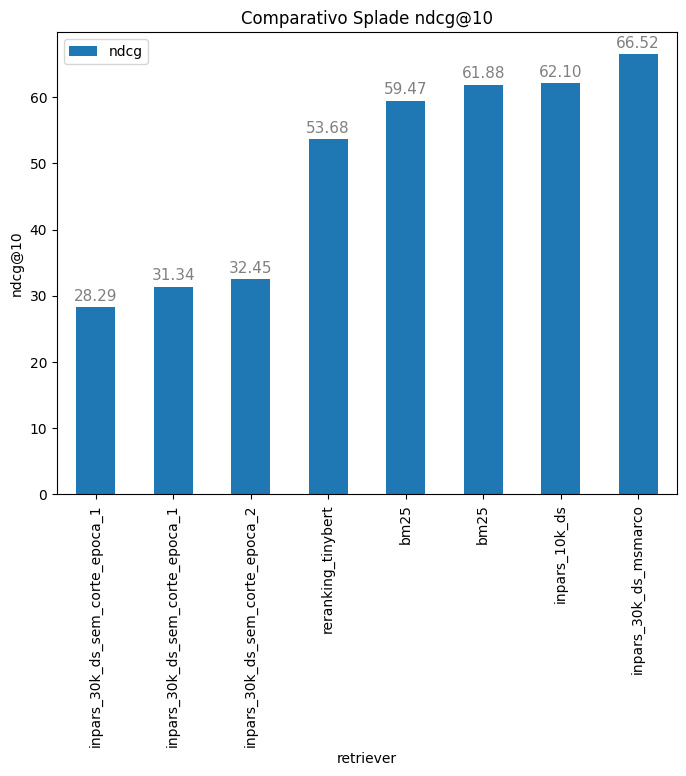

In [160]:

# Transforma a lista em um DataFrame
df = pd.DataFrame(lista_resultados)

# Ordena os valores de acordo com o ndcg
df = df.sort_values(by='ndcg', ascending=True)

# Plota o gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
ax = df.plot(kind='bar', x='retriever', y='ndcg', rot=0, ax=ax)

# Adiciona os valores de ndcg acima das barras
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 8),
                textcoords='offset points')

# Configura os eixos e título do gráfico
ax.set_xticklabels(df['retriever'],rotation=90)
ax.set_title(f'Comparativo Splade ndcg@10')
ax.set_ylabel('ndcg@10')
plt.show()


In [141]:
df_reranking_entrada.columns

Index(['query', 'q0', 'docid', 'rank_estagio1', 'score_estagio1', 'query_text',
       'doc_text', 'score_tinybert', 'score_inpars_10k_ds',
       'score_inpars_30k_ds_msmarco', 'score_inpars_30k_ds_sem_corte_epoca_1'],
      dtype='object')

In [143]:
# Seleciona as colunas do dataframe original
cols = ['query', 'q0', 'docid', 'rank_estagio1', 'score_estagio1', 'query_text', 'doc_text']

# Cria uma lista para armazenar as linhas do novo dataframe
new_rows = []

# Itera sobre as linhas do dataframe original
for idx, row in df_reranking.iterrows():
    # Itera sobre as colunas que começam com "score_"
    for col in df_reranking.filter(regex='^score_'):
        # Obtém o nome do retriever a partir do nome da coluna
        retriever = col.replace('score_', '')
        # Cria uma nova linha com as informações da linha original e as colunas "score" e "retriever"
        new_row = row[cols].to_dict()
        new_row['score'] = row[col]
        new_row['retriever'] = retriever
        # Adiciona a nova linha à lista
        new_rows.append(new_row)

# Cria um novo dataframe com as linhas da lista
df_new = pd.DataFrame(new_rows)


In [144]:
df_new.shape

(200000, 9)

In [145]:

# Reordena as colunas do novo dataframe
df_new = df_new[['query', 'q0', 'docid', 'rank_estagio1', 'score_estagio1', 'query_text', 'doc_text', 'score', 'retriever']]



In [146]:
df_new.shape

(200000, 9)

In [147]:
df_new.head()

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score,retriever
0,1,q0,jeuwaj50,226,3.895198,what is the origin of COVID-19,COVID-19—What we know and what we need to know...,3.895198,estagio1
1,1,q0,jeuwaj50,226,3.895198,what is the origin of COVID-19,COVID-19—What we know and what we need to know...,0.183529,tinybert
2,1,q0,jeuwaj50,226,3.895198,what is the origin of COVID-19,COVID-19—What we know and what we need to know...,0.999184,inpars_10k_ds
3,1,q0,jeuwaj50,226,3.895198,what is the origin of COVID-19,COVID-19—What we know and what we need to know...,0.998415,inpars_30k_ds_msmarco
4,1,q0,9puijlym,874,3.389897,what is the origin of COVID-19,What is the role of rheumatologists in the era...,3.389897,estagio1


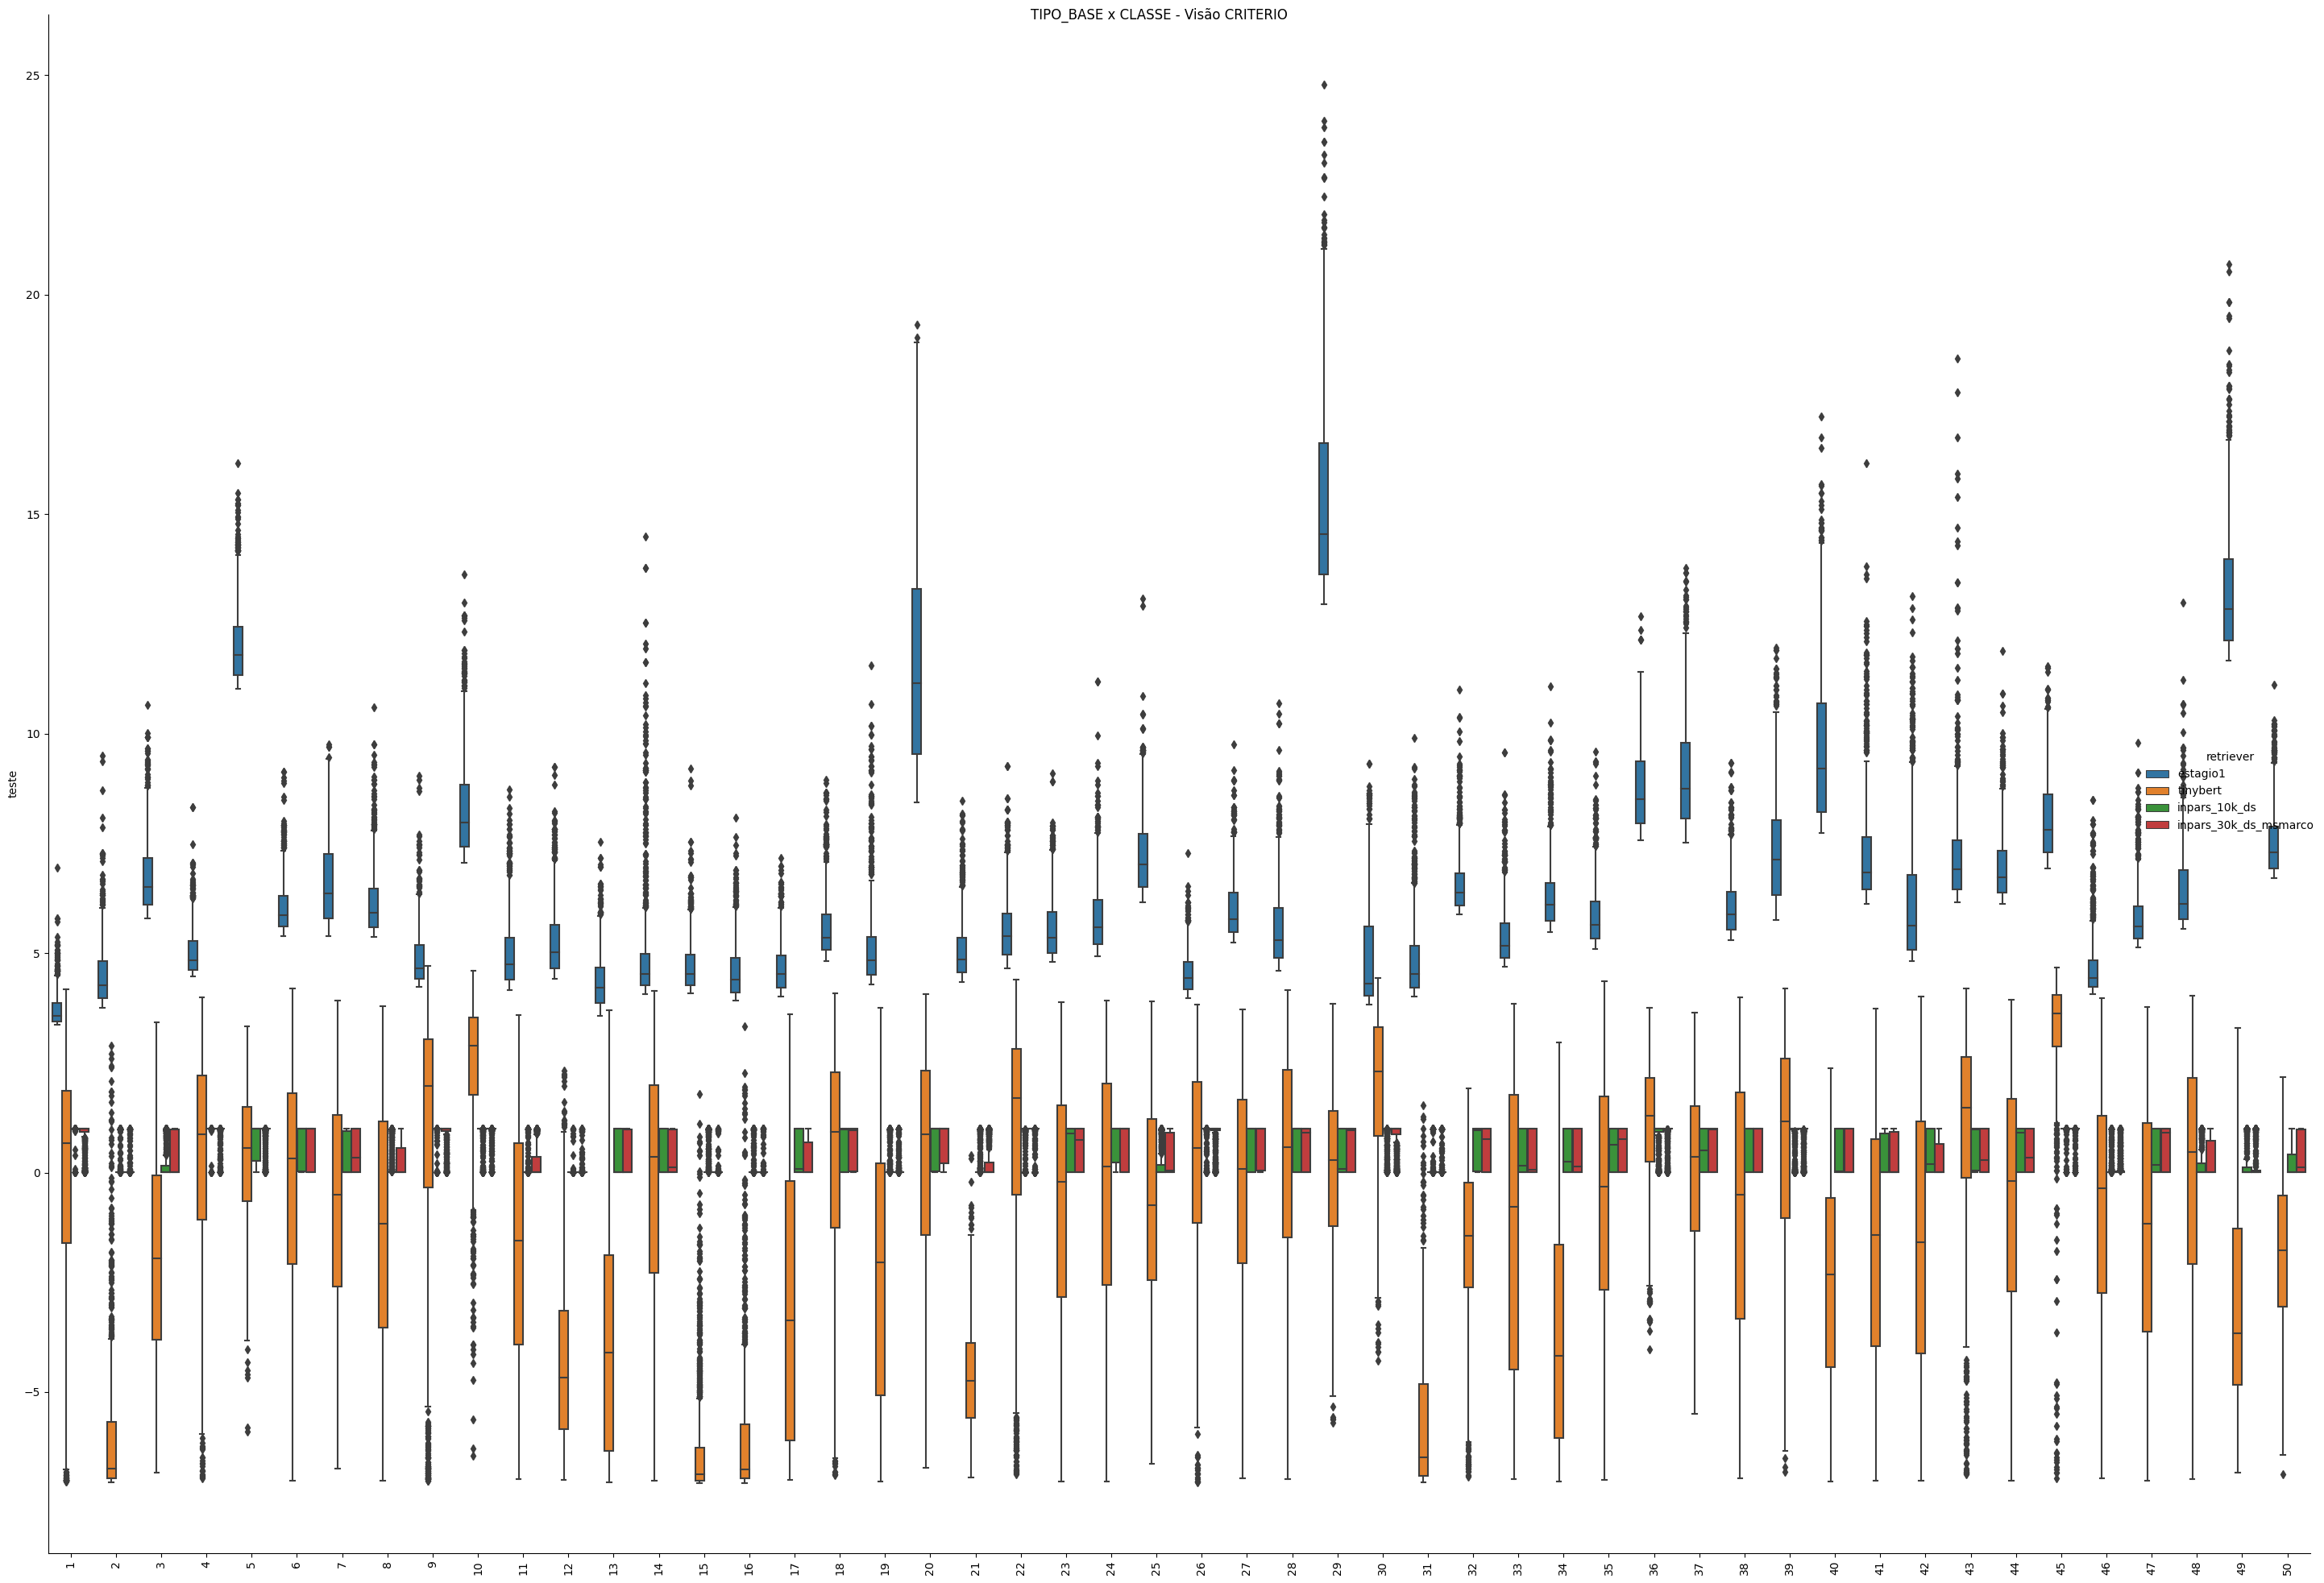

In [151]:
g = sns.catplot(x="query", sharex=True, y="score", hue='retriever',
                kind="box", data=df_new, height=20, aspect=20/15) # row="CLASSE", 
g.fig.suptitle('TIPO_BASE x CLASSE - Visão CRITERIO')
g.set_xticklabels(rotation=90)
g.set_axis_labels("", 'teste')
plt.tight_layout()
plt.show()

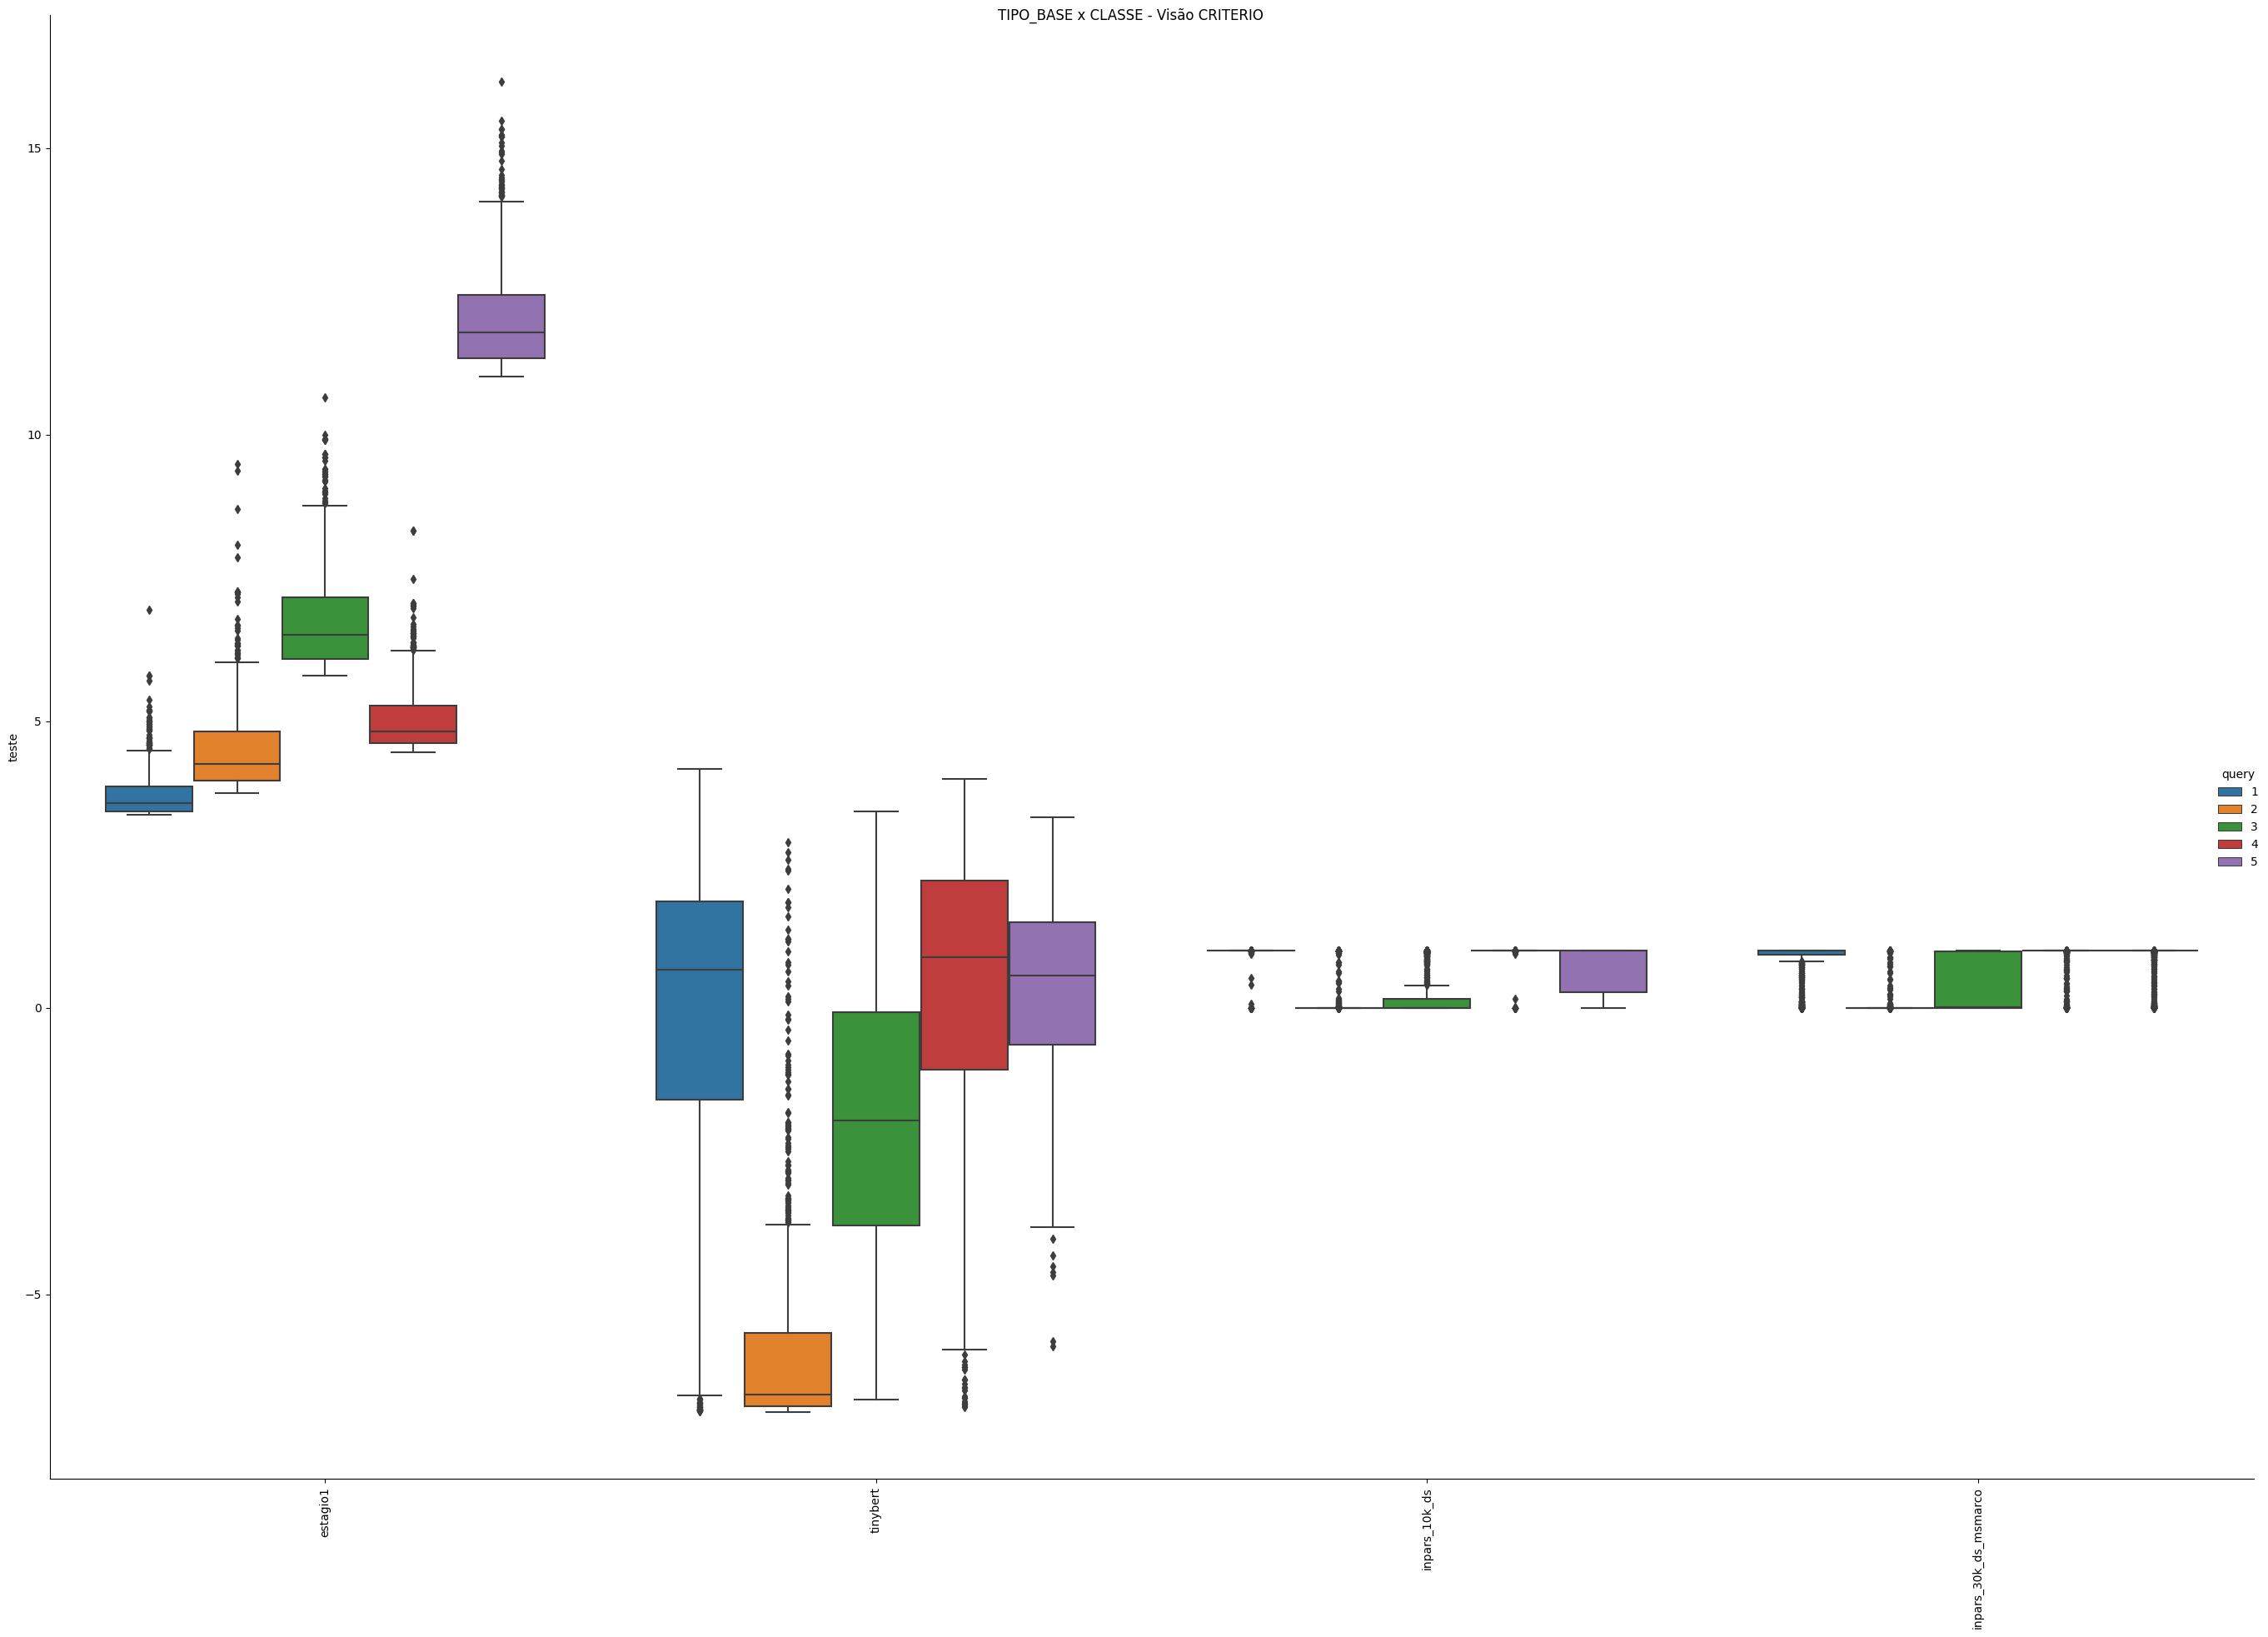

In [154]:
g = sns.catplot(x="retriever", sharex=True, y="score", hue='query',
                kind="box", data=df_new[df_new['query']<=5], height=20, aspect=20/15) # row="CLASSE", 
g.fig.suptitle('TIPO_BASE x CLASSE - Visão CRITERIO')
g.set_xticklabels(rotation=90)
g.set_axis_labels("", 'teste')
plt.tight_layout()
plt.show()

In [155]:
from sklearn.preprocessing import MinMaxScaler

In [156]:
df_reranking_norm = df_reranking.copy()

In [157]:
# Selecionar as colunas que começam com "score_"
score_cols = [col for col in df_reranking.columns if col.startswith('score_')]

# Normalizar as colunas selecionadas
scaler = MinMaxScaler()
df_reranking[score_cols] = scaler.fit_transform(df_reranking[score_cols])


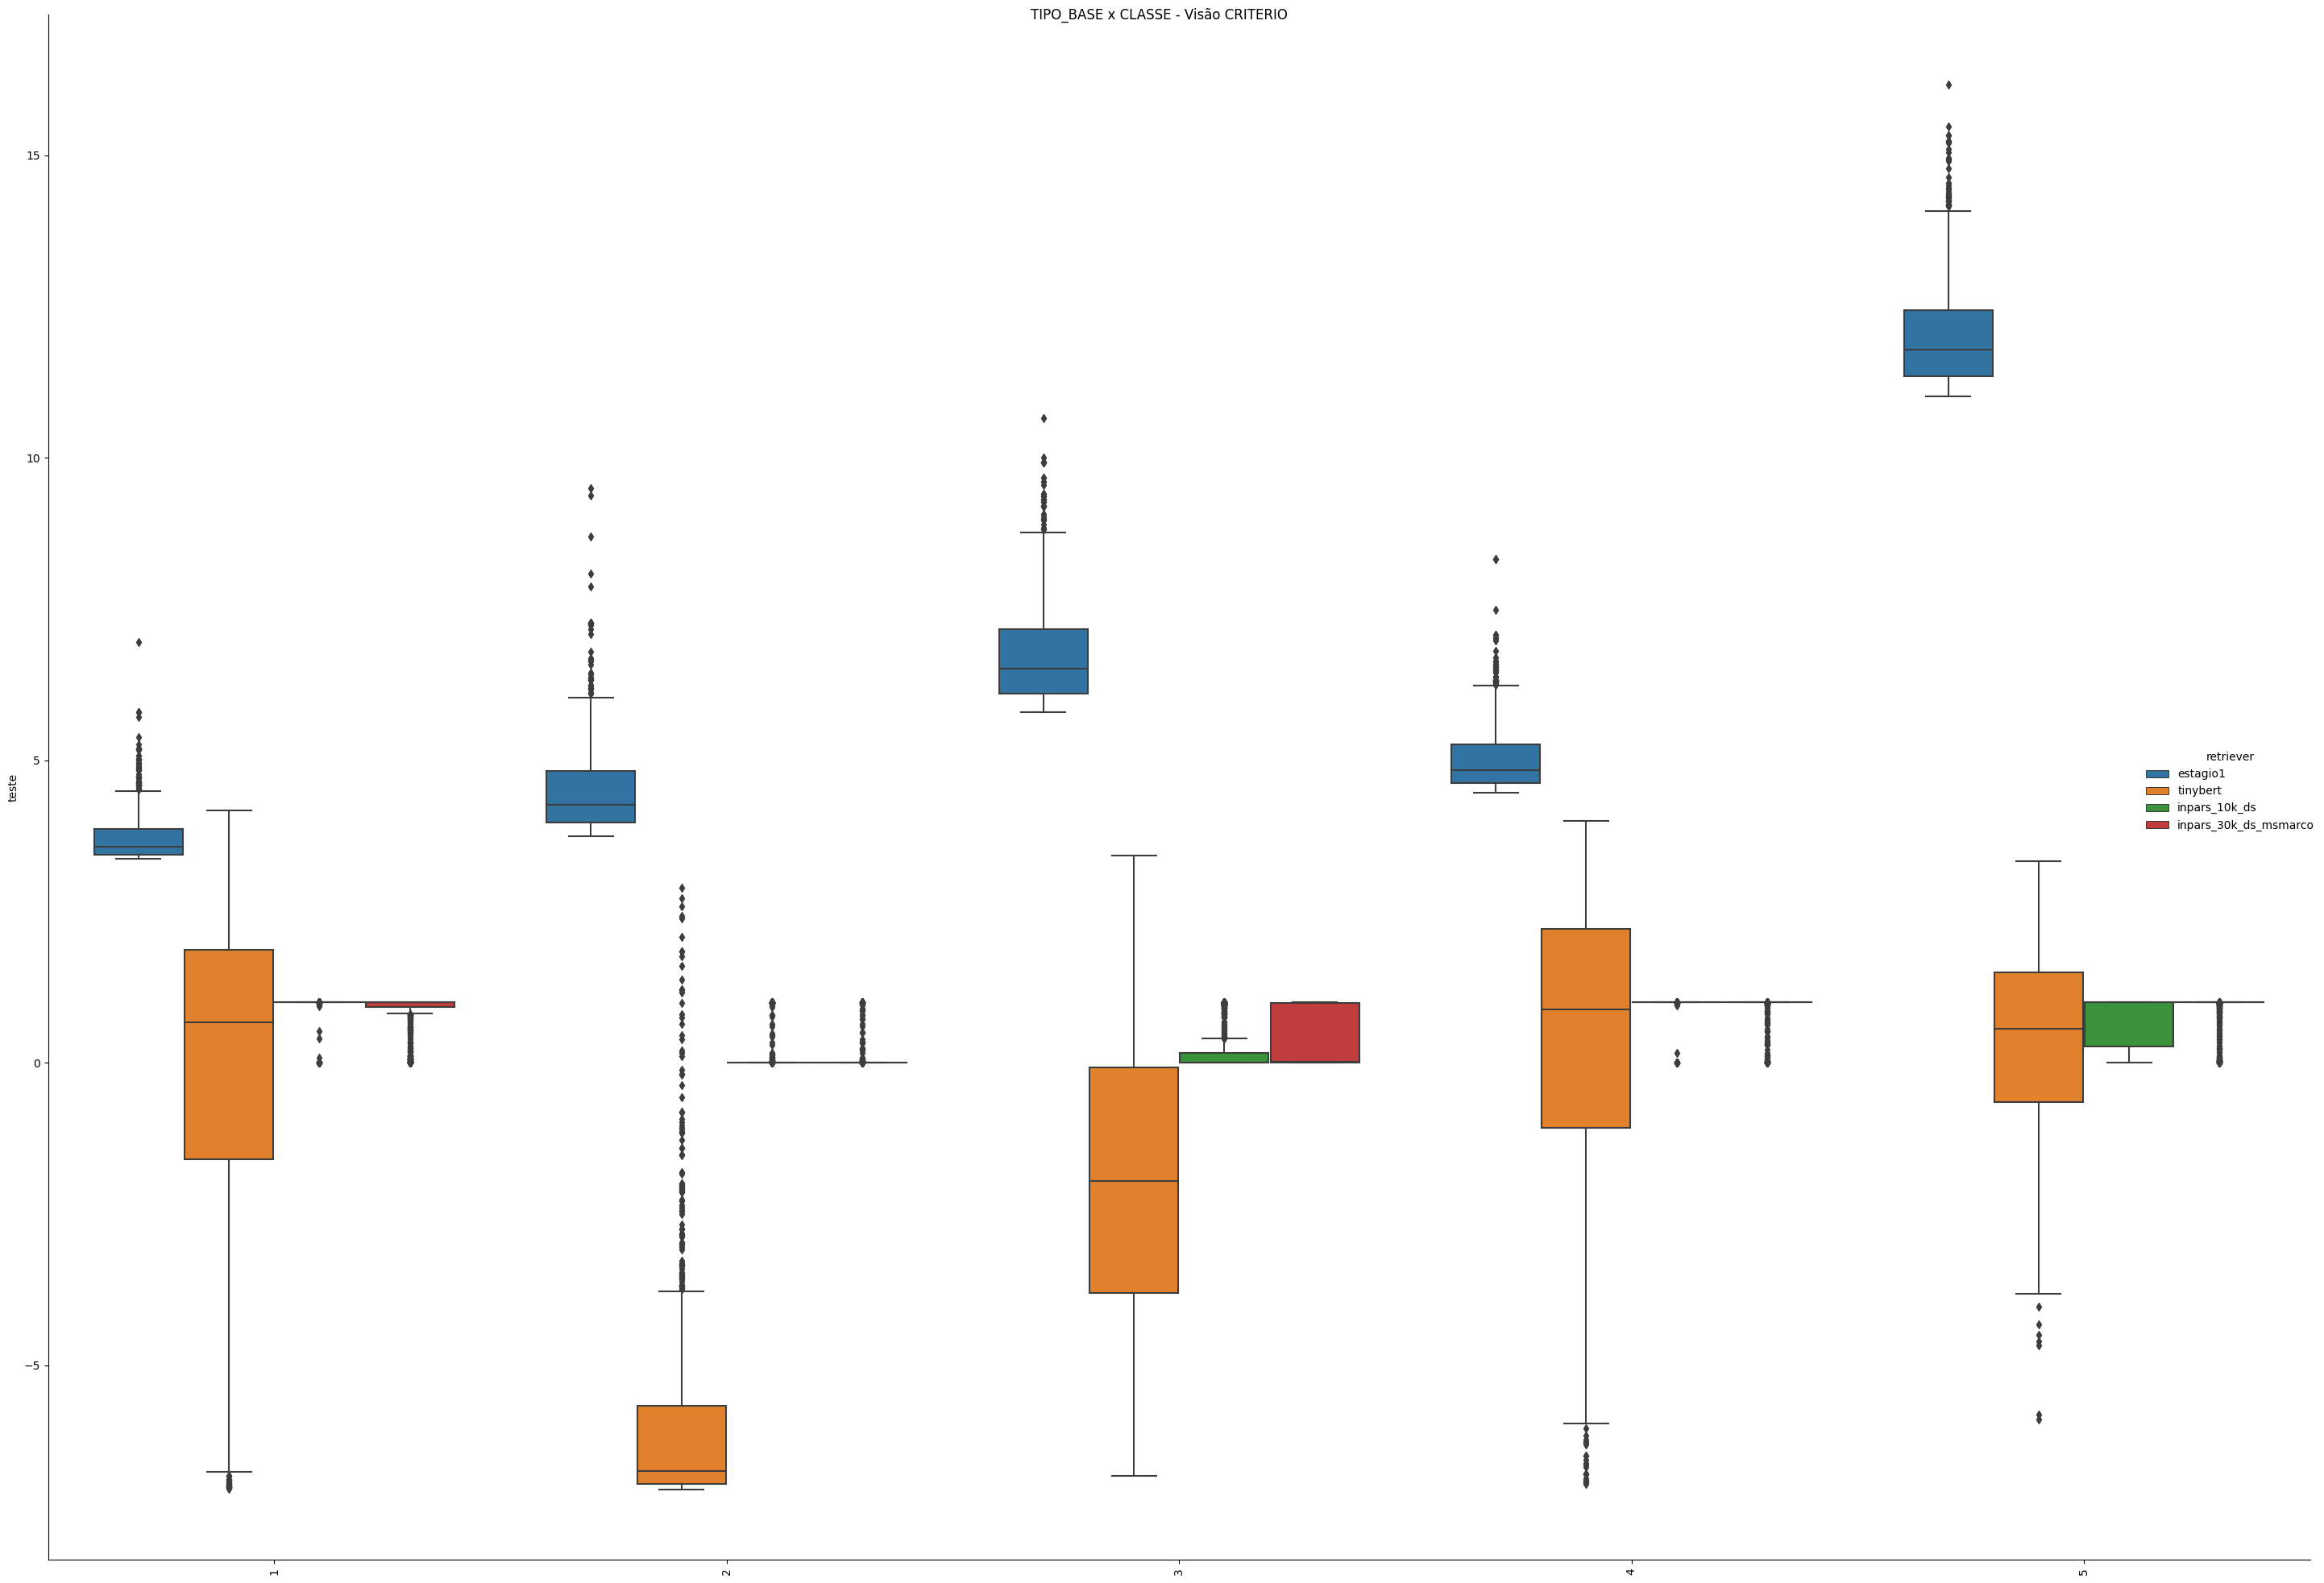

In [159]:
g = sns.catplot(x="query", sharex=True, y="score", hue='retriever',
                kind="box", data=df_new[df_new['query']<=5], height=20, aspect=20/15) # row="CLASSE", 
g.fig.suptitle('TIPO_BASE x CLASSE - Visão CRITERIO')
g.set_xticklabels(rotation=90)
g.set_axis_labels("", 'teste')
plt.tight_layout()
plt.show()

Testar sem shift no exemplo negativo e para épocas 1, 2 e 3

In [ ]:
df_reranking_entrada.to_csv(f"{DIRETORIO_TRABALHO}/df_reranking.csv")

In [ ]:
with open(PATH_LISTA_RESULTADO, 'wb') as outputFile:
    pickle.dump(lista_resultados, outputFile, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(PATH_LISTA_RESULTADO, 'rb') as f:
    lista_resultados = pickle.load(f)